In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import numpy.random as random
import scipy.io, scipy.interpolate
import matplotlib.pyplot as plt

## Notation

* $\theta$: the parameters we're trying to infer; in David's model, that's either the accumulation or velocity scaling factors
* $\phi$: the "momentum", you'll see what I mean in a bit
* $P(\theta)$: the probability density function of the parameters
* $\tau$: a fictitious, made-up time (ex: the lifespan of RBG, clearly she's immortal)

## Review & motivation

Say we want to sample from some probability density $P(\theta)$.
There are two parts to MCMC sampling:

* The **transition probability** $Q(\theta_{k + 1} | \theta_k)$: given a state $\theta_k$, the next candidate $\theta_{k + 1}$ is generated by sampling from $Q(\theta | \theta_k)$.
* The **accept/reject** criterion: accept $\theta_{k + 1}$ with probability $\min(1, P(\theta_{k + 1})/P(\theta_k))$.

Usually, $Q(\theta_{k + 1} | \theta_k)$ = normal distribution with mean $\theta_k$.
But this choice is arbitrary and we could use anything, so long as the transitions are reversible: $Q(\theta' | \theta) = Q(\theta | \theta')$.

**Hamiltonian Monte Carlo is a clever choice of transition probability.**
Rather than try to guess randomly where to go from the current parameters, HMC uses information from the contours/gradient of the density $P$ (really $-\log P$) to guide the search.

Lots of algorithms (stochastic gradient descent, simulated annealing, etc.) go down-gradient to find modes of $P$.
This is essentially like solving the ODE

$$\frac{d}{d\tau}\theta - \nabla\log P = 0.$$

The solutions of this ODE as the fictitious time $\tau$ goes to $\infty$ go to extrema.
As we've seen this tends to get stuck in local extrema and you need tricks to make it explore everywhere.
HMC instead uses a second-order ODE

$$\frac{d^2}{d\tau^2}\theta - \nabla\log P = 0$$

to make the guesses oscillate around the modes.

## Hamiltonian mechanics

**Hamiltonian mechanics** is a particular way of describing classical physical systems.

* **The players**: position $\theta$, momentum $\phi$, and the total energy $H(\theta, \phi)$ of the system
* **The rules**: Hamilton's equations of motion,
$$\begin{align}
\dot \theta & = +\frac{\partial H}{\partial \phi} \\
\dot \phi & = -\frac{\partial H}{\partial \theta}
\end{align}$$
* When $\phi = m\dot \theta$, and $H = $ kinetic energy + potential energy, Hamilton's equations of motion are equivalent to Newton's.

Some very important things:
* The energy $H$ is conserved along trajectories of the ODE.
* The volume in phase space is conserved.
Take a "blob" $D$ of position/momentum pairs, now evolve them all for a time $\tau$ using Hamilton's equations; this gives a morphed blob, $D_\tau$.
Then $\mathrm{vol}(D) = \mathrm{vol}(D_\tau)$.
* Hamiltonian dynamics is *reversible* -- flipping all the momenta $\Leftrightarrow$ going backwards in time.

## Hamiltonian Monte Carlo

MCMC simulation works with any reversible transition kernel.
The idea of HMC is to augment the state $\theta$ with a *pseudo-momentum* variable $\phi$ and use Hamiltonian dynamics to update both $\theta$ and $\phi$.

The algorithm:

0. Pick a starting parameter $\theta_0$ however you like.
1. Pick a starting momentum $\phi_0$ sampled from a normal distribution.
2. Solve Hamilton's equation's of motion up to some time $\tau$.
3. Accept/reject the new state $\theta_\tau, \phi_\tau$ according to the usual MCMC criterion:
$$\min\{1, \exp\left[H(\theta_0, \phi_0) - H(\theta_\tau, \phi_\tau)\right]\}$$
4. Throw out the momentum and go back to (1).

If we were able to solve Hamilton's equations exactly, the energy would be conserved and we would always accept the new state!

You can think of HMC as a way to sample from the PDF at two distinct levels at each step.
* Random magnitude of $\phi$ $\Rightarrow$ sampling *across* energy contours.
* Random direction of $\phi$ + solving Hamilton's equations $\Rightarrow$ sampling *along* energy contours.

## Some real data

Let's try and apply this to David's data from last week.
We're going to do a little more cleaning up to remove duplicate points.

In [2]:
layers = scipy.io.loadmat('layers.mat')
sx, sy = layers['psx_layers'][0], layers['psy_layers'][0]
dx = np.sqrt(np.diff(sx)**2 + np.diff(sy)**2)
x = np.hstack(([0], np.cumsum(dx)))[:5000]
target_layer = layers['layer_14'][0][:5000]

# Find any points that are duplicated or where there's data missing and remove them
repeat_point_indices = np.where(dx < 1.0)[0] + 1
no_data_indices = np.where(np.isnan(target_layer))[0]
good_indices = set(range(5000)) - set(repeat_point_indices) - set(no_data_indices)
indices = np.array(list(good_indices))
indices.sort()

x = x[indices]
target_layer = target_layer[indices]

In [3]:
more_data = scipy.io.loadmat('vels.mat')
vel_interpolater = scipy.interpolate.interp1d(more_data['dists'][0], more_data['vels'][0])
u = vel_interpolater(x)
acc_interpolater = scipy.interpolate.interp1d(more_data['acc_dists'][0], more_data['acc'][0])
a = acc_interpolater(x) * 1.4  # need a little cheating to help us along

Given the present-day accumulation rate $a(x)$, ice velocity $u(x)$, and the scaling factors $s_a(t)$, $s_u(t)$, David's model for the layer depth $z$ is the solution of the advection equation

$$\frac{\partial z}{\partial t} - s_u(t)u(x)\frac{\partial z}{\partial x} = s_a(t) \cdot DJ(a, z),$$

$$\frac{\partial z}{\partial x}\Big|_{x = L} = 0.$$

up to the final time $t_f$, where $DJ$ is the Dansgaard-Johnsen model for the vertical velocity.
David used an arbitrary Lagrangian-Eulerian scheme to solve these equations.

**One of the hard parts of using HMC is calculating derivatives of the objective w.r.t. the parameters.**
To be able to calculate derivatives, I had to use a more old-fashioned backward Euler integration scheme to solve the model physics.
I calculated the derivatives using the adjoint method.
The derivatives were very inaccurate without a small timestep.

In [4]:
import model

total_time = 725.0
num_steps = 40

accumulation_scale = 1.08 * np.ones(num_steps)
velocity_scale = 1.05 * np.ones(num_steps)

z = model.layer_depth(x, accumulation_scale, velocity_scale,
                      a, u, total_time, num_steps)

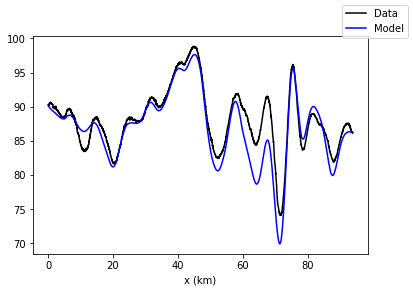

In [5]:
fig, ax = plt.subplots()
ax.plot(x/1000, target_layer, color='k', label='Data')
ax.plot(x/1000, z[num_steps - 1, :], color='b', label='Model')
ax.set_xlabel("x (km)")
fig.legend()
plt.show(fig)

To calculate the derivative of the model-data misfit with respect to the input parameters, I used the adjoint method.

In [6]:
dJ_da = model.derivative_ascale(x, accumulation_scale, velocity_scale,
                                a, u, z, target_layer,
                                total_time, num_steps)

The figure below shows the sensitivity of the mean-square error to changes in the accumulation scale over time.

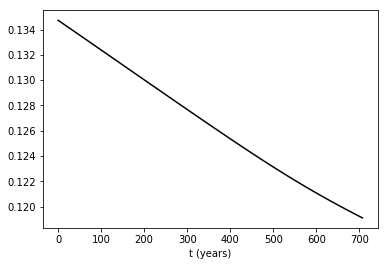

In [7]:
dt = total_time / num_steps
fig, ax = plt.subplots()
ax.plot(np.array(range(num_steps)) * dt, dJ_da, color='k')
ax.set_xlabel('t (years)')
plt.show(fig)

Next, let's compute the expected decrease in the mean-square error, assuming that we perturbed the accumulation scale by going down-gradient.

In [8]:
da = -dJ_da
dJ = np.dot(dJ_da, da) * dt
print("{:e}".format(dJ))

-1.163425e+01


To make sure I implemented everything right, we can calculate the actual decrease in the error and see how well it agrees with the value `dJ` computed above.

In [9]:
error_0 = model.mean_square_misfit(x, z[-1, :], target_layer)
print("{}".format(error_0))

for k in range(20):
    δ = 1.0/2**k
    zk = model.layer_depth(x, accumulation_scale + δ * da, velocity_scale,
                           a, u, total_time, num_steps)
    error = model.mean_square_misfit(x, zk[-1, :], target_layer)
    
    print("{}, {}".format((error - error_0)/δ, dJ))

2.631288271887528
42.03830443049137, -11.634245973319864
15.537722250588645, -11.634245973319864
2.330091636973476, -11.634245973319864
-4.263081677910613, -11.634245973319864
-7.557010723381303, -11.634245973319864
-9.20331120357028, -11.634245973319864
-10.026295478065208, -11.634245973319864
-10.437746129541324, -11.634245973319864
-10.643461084538217, -11.634245973319864
-10.746315969446187, -11.634245973319864
-10.797742763741553, -11.634245973319864
-10.82345599888231, -11.634245973319864
-10.836312575971533, -11.634245973319864
-10.842740854306612, -11.634245973319864
-10.845954991033068, -11.634245973319864
-10.84756205897429, -11.634245973319864
-10.848365592129994, -11.634245973319864
-10.84876735979924, -11.634245973319864
-10.848968240781687, -11.634245973319864
-10.84906868939288, -11.634245973319864


This isn't too bad given the discretization.
I might still have made an error somewhere -- the velocity derivatives, while in the right direction, are usually off by a factor of 2.


## Skeleton of HMC

We now have everything in place to start sampling from the PDF for David's data and model!

In order to make the runs reproducible, we'll use a `RandomState` object from numpy for all our random number generation.
If some run is particularly interesting, we can serialize the random state object, save it to disk, and deserialize it later when we want to reproduce the run identically.
This involves some extra book-keeping but you should always do it.

In [10]:
random_state = random.RandomState()

Last week, we discussed using regularization in order to select for smooth values of the parameters; this is equivalent to a certain choice of prior in Bayesian inference.
We'll do the same thing this time.
**How you regularize the problem determines the choice of mass matrix**, i.e. how the different components of the momentum vector are coupled together.

Note how we divide by the square root of the number of time steps to get the right total variance.

In [11]:
r = 20
import scipy.sparse, scipy.sparse.linalg, numpy.linalg
Id = scipy.sparse.diags([np.ones(num_steps)], [0])
diag = np.ones(num_steps)
D = scipy.sparse.diags([diag, -diag], [0, 1], shape=(39, 40)) / dt
L = r**2 * D.T * D * dt
M = Id + L

λs, vs = numpy.linalg.eigh(M.toarray())

def generate_momentum(random_state, σ):
    ζ = random_state.normal(size=num_steps)
    return sum(((ζ[k] * np.sqrt(λs[k] / num_steps) * σ) * vs[:, k] for k in range(num_steps)))

The following functions calculate each part of the Hamiltonian and its derivatives.
The final term in the potential -- `np.dot(θ, L * θ)` -- is what adds the penalty for oscillatory solutions.

In [12]:
def potential_energy(θ):
    z_θ = model.layer_depth(x, θ, velocity_scale,
                            a, u, total_time, num_steps)
    return model.mean_square_misfit(x, z_θ[-1,:], target_layer) + \
           0.5 * np.dot(θ, L * θ)

def kinetic_energy(ϕ):
    return 0.5 * np.dot(ϕ, scipy.sparse.linalg.spsolve(M, ϕ))

def force(θ):
    z_θ = model.layer_depth(x, θ, velocity_scale,
                            a, u, total_time, num_steps)
    return -model.derivative_ascale(x, θ, velocity_scale,
                                    a, u, z_θ, target_layer,
                                    total_time, num_steps) - L * θ

def velocity(ϕ):
    return scipy.sparse.linalg.spsolve(M, ϕ)

This function implements the Verlet method for numerically integrating a Hamiltonian system.

In [13]:
def hamiltonian_update(δτ, θ, ϕ):
    θ_τ = θ + 0.5 * δτ * velocity(ϕ)
    ϕ_τ = ϕ + δτ * force(θ)
    θ_τ += 0.5 * δτ * velocity(ϕ_τ)
    return θ_τ, ϕ_τ 

Create the initial parameter and momentum and plot the velocity.
The initial kinetic energy should be around 0.5 (it's a $\chi^2$ random variable).

0.29495644383126696


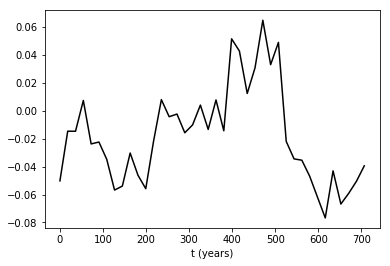

In [14]:
θ = accumulation_scale.copy()
ϕ = generate_momentum(random_state, 1)

print(kinetic_energy(ϕ))

fig, ax = plt.subplots()
ax.plot(np.array(range(num_steps)) * dt, velocity(ϕ), color='k')
ax.set_xlabel('t (years)')
plt.show(fig)

Solve the system using a fictitious timestep of 1/32 for 2/3 of a fictitious time unit.
I had to hand-tune both of these parameters to get something sensible.

In [15]:
δτ = 1.0/32
num_hamiltonian_steps = int(2.0 / 3 / δτ)

for k in range(num_hamiltonian_steps):
    θ, ϕ = hamiltonian_update(δτ, θ, ϕ)
    print(kinetic_energy(ϕ), potential_energy(θ))

0.298061812140863 2.5801840302474996
0.301082023860451 2.5227703864722795
0.3038884876369661 2.461264314224819
0.30634153946372 2.398074943587992
0.3082958837983512 2.33571198252503
0.3096063754200919 2.2766892987614784
0.3101339200361003 2.22342735881386
0.309751264413126 2.178158304509398
0.3083484483876756 2.1428373853002434
0.30583770154163553 2.1190642576199514
0.30215758632674794 2.1080173166962726
0.29727621635134144 2.1104037533198006
0.29119341246130825 2.126427444848437
0.2839416989249813 2.155776117505622
0.27558608599716056 2.197628480866329
0.26622263173158 2.25068126324476
0.2559758233472746 2.3131952982272055
0.24499486488739033 2.3830590582408724
0.23344900150629497 2.457867330705486
0.22152204973487138 2.5350121141788033
0.2094063359126984 2.61178230132777


Compute a few statistics of the resulting random state.

In [16]:
print(np.min(θ), np.max(θ))

1.0192477983630548 1.1076304933197387


In [17]:
print(kinetic_energy(ϕ))

0.2094063359126984


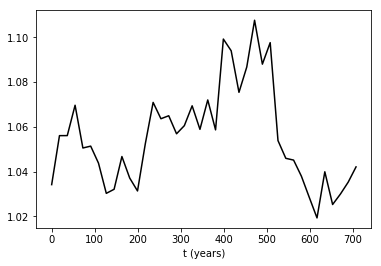

In [18]:
fig, ax = plt.subplots()
ax.plot(np.array(range(num_steps)) * dt, θ, color='k')
ax.set_xlabel('t (years)')
plt.show(fig)

In [19]:
print(potential_energy(θ), potential_energy(accumulation_scale))

2.61178230132777 2.631288271887528


The resulting layer depth undershoots pretty dramatically.

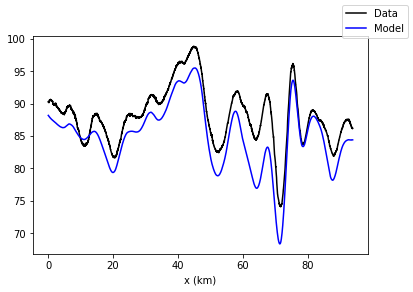

In [20]:
z_θ = model.layer_depth(x, θ, velocity_scale,
                        a, u, total_time, num_steps)

fig, ax = plt.subplots()
ax.plot(x/1000, target_layer, color='k', label='Data')
ax.plot(x/1000, z_θ[num_steps - 1, :], color='b', label='Model')
ax.set_xlabel("x (km)")
fig.legend()
plt.show(fig)

## HMC sampling

Now let's generate a bunch of samples and see what the resulting ensemble looks like.

In [21]:
num_samples = 20
θs = np.zeros((num_samples, num_steps))
θs[0, :] = accumulation_scale.copy()
for sample in range(1, num_samples):
    ϕ = generate_momentum(random_state, 1)
    θ = θs[sample - 1, :].copy()

    for k in range(num_hamiltonian_steps):
        θ, ϕ = hamiltonian_update(δτ, θ, ϕ)
        
    print(kinetic_energy(ϕ), potential_energy(θ))
    θs[sample, :] = θ.copy()

0.35296705045866866 2.2987164335136696
0.4711716424206045 2.4212092792459776
0.40557986603311974 2.4780376147097893
0.6816129627274387 2.44329328726397
0.40544374426635377 2.5356174357349506
0.35228111083162844 2.686270336845403
0.4689757139173307 2.7609847480322167
0.5500345330324384 2.7389589158400174
0.36248847604352397 3.3635808270219156
0.8237661146866937 3.2592987968644143
0.39744868324123495 4.26123296965819
0.6041169618438412 4.12165230084197
0.5623040947651528 2.9149314958905927
0.48051530500568024 2.7906924613313286
0.5853418923640387 2.8401496056886106
0.5088772044413451 4.803144616202384
0.6993394351159278 3.0032501781771055
0.4179906057896303 2.8102384797294158
0.6075853614697643 2.9593831076143005


Lighter colors are earlier runs, darker colors are later ones.
We can clearly see the guesses migrating through parameter space.

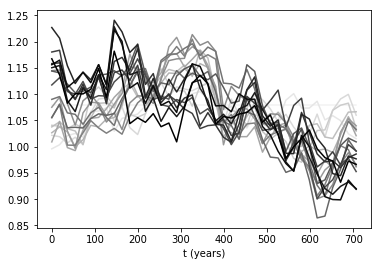

In [22]:
colormap = plt.get_cmap('binary')

fig, ax = plt.subplots()
for sample in range(num_samples):
    ax.plot(np.array(range(num_steps)) * dt, θs[sample, :],
            color=colormap((sample + 1) / num_samples))
ax.set_xlabel('t (years)')
plt.show(fig)

Despite the differences in the parameter values, the resulting ice layers are very clustered.

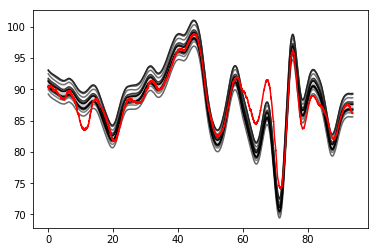

In [23]:
fig, ax = plt.subplots()
for sample in range(num_samples):
    θ = θs[sample, :]
    z_θ = model.layer_depth(x, θ, velocity_scale,
                            a, u, total_time, num_steps)
    ax.plot(x/1000, z_θ[-1, :], color=colormap((sample + 1) / num_samples))
    ax.plot()
    
ax.plot(x/1000, target_layer, color='r')
plt.show(fig)